In [ ]:

# Run these in a separate cell FIRST, then RESTART the kernel (Runtime > Restart session),
# then run the main script in a new cell.

!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless opencv-contrib-python-headless
!pip install "numpy<2.0" --force-reinstall
!pip install opencv-python-headless==4.10.0.84
!pip install ultralytics --no-deps

# After install, RESTART KERNEL before running the training script!

In [1]:


from ultralytics import YOLO
import os
import shutil
from pathlib import Path
import cv2
import numpy as np
from PIL import Image

# Configuration
DATA_PATH = "/kaggle/input/banglabengali-license-plate-with-number-detection"
TASK = "Vehicle_to_License_Plate"
WORK_DIR = "/kaggle/working/dataset"
OUTPUT_MODEL = "best_yolov8_license_plate.pt"
EPOCHS = 50
IMG_SIZE = 640
BATCH_SIZE = 16

print("=" * 70)
print("YOLOV8 LICENSE PLATE DETECTION - TRAINING (KAGGLE 2026 FIXED)")
print("=" * 70)

# Copy dataset
print("\n[1/10] Copying dataset...")
source_path = os.path.join(DATA_PATH, TASK)
if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
for split in ["train", "val", "test"]:
    for subdir in ["images", "labels"]:
        src = os.path.join(source_path, split, subdir)
        dst = os.path.join(WORK_DIR, split, subdir)
        os.makedirs(dst, exist_ok=True)
        if os.path.exists(src):
            for f in os.listdir(src):
                shutil.copy2(os.path.join(src, f), dst)
print("✓ Dataset copied")

# Safe sanitization (kept for safety)
print("\n[2/10] Safe sanitization...")
def sanitize_images(img_dir, label_dir):
    removed = []
    for f in [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]:
        img_path = os.path.join(img_dir, f)
        try:
            data = np.fromfile(img_path, dtype=np.uint8)
            img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                raise Exception
        except:
            try:
                Image.open(img_path).verify()
            except:
                removed.append(f)
                os.remove(img_path)
                lbl = os.path.splitext(f)[0] + ".txt"
                lbl_path = os.path.join(label_dir, lbl)
                if os.path.exists(lbl_path):
                    os.remove(lbl_path)
    return removed

for split in ["train", "val", "test"]:
    img_dir = os.path.join(WORK_DIR, split, "images")
    lbl_dir = os.path.join(WORK_DIR, split, "labels")
    if os.path.exists(img_dir):
        bad = sanitize_images(img_dir, lbl_dir)
        print(f" {split}: removed {len(bad)} corrupt images")

# Dataset summary
print("\n[3/10] Dataset summary:")
for split in ["train", "val", "test"]:
    imgs = len(os.listdir(os.path.join(WORK_DIR, split, "images"))) if os.path.exists(os.path.join(WORK_DIR, split, "images")) else 0
    lbls = len(os.listdir(os.path.join(WORK_DIR, split, "labels"))) if os.path.exists(os.path.join(WORK_DIR, split, "labels")) else 0
    print(f" {split}: {imgs} images | {lbls} labels")

# data.yaml
print("\n[4/10] Writing data.yaml")
yaml_text = f"""
path: {WORK_DIR}
train: train/images
val: val/images
test: test/images
nc: 1
names:
  0: license_plate
"""
with open("data.yaml", "w") as f:
    f.write(yaml_text.strip())
print("✓ data.yaml ready")

# Load & train
print("\n[5/10] Loading model")
model = YOLO("yolov8n.pt")

print("\n[6/10] Training started")
results = model.train(
    data="data.yaml",
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=0,
    project="license_plate_detection",
    name="run",
    exist_ok=True,
    patience=15,
    amp=False,
    workers=2,
    cache=False,
    optimizer="auto",
    pretrained=True,
    val=True,
    plots=True,
    verbose=True,
    augment=False
)



print("\nDONE! Training should now run successfully ")

YOLOV8 LICENSE PLATE DETECTION - TRAINING (KAGGLE 2026 FIXED)

[1/10] Copying dataset...
✓ Dataset copied

[2/10] Safe sanitization...


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 train: removed 0 corrupt images
 val: removed 0 corrupt images


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 test: removed 0 corrupt images

[3/10] Dataset summary:
 train: 1350 images | 1350 labels
 val: 385 images | 385 labels
 test: 194 images | 194 labels

[4/10] Writing data.yaml
✓ data.yaml ready

[5/10] Loading model

[6/10] Training started
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       1/50      4.38G      1.458      2.104      1.381         11        640: 100% ━━━━━━━━━━━━ 85/85 3.3it/s 26.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 2.8it/s 4.6s0.2s
                   all        385        403      0.785      0.675      0.786      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      4.39G      1.393       1.42      1.312         28        640: 18% ━━────────── 15/85 3.7it/s 4.3s<18.8s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       2/50      4.39G      1.445      1.328      1.344         14        640: 100% ━━━━━━━━━━━━ 85/85 3.8it/s 22.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s0.3s
                   all        385        403      0.774      0.789      0.813      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      4.41G      1.453      1.217      1.381         41        640: 13% ━╸────────── 11/85 3.6it/s 3.3s<20.4s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       3/50      4.42G      1.482      1.172      1.373         13        640: 100% ━━━━━━━━━━━━ 85/85 3.7it/s 23.1s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s0.3s
                   all        385        403      0.743      0.654      0.685      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      4.43G      1.467       1.04      1.366         31        640: 55% ━━━━━━╸───── 47/85 3.8it/s 12.9s<10.1s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       4/50      4.43G      1.457      1.021      1.377         11        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s0.3s
                   all        385        403      0.903      0.888      0.938      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      4.44G      1.451      0.928      1.357         28        640: 75% ━━━━━━━━━─── 64/85 3.7it/s 18.2s<5.7ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       5/50      4.44G      1.443     0.9189      1.354         33        640: 94% ━━━━━━━━━━━─ 80/85 3.7it/s 22.5s<1.4s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       5/50      4.45G      1.442      0.916      1.352         14        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 3.0s0.2s
                   all        385        403       0.87      0.898      0.921      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      4.47G      1.431      0.877      1.356         12        640: 100% ━━━━━━━━━━━━ 85/85 3.7it/s 23.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.5it/s 3.7s0.3s
                   all        385        403      0.928      0.871      0.931      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       7/50      4.48G      1.425     0.8396      1.354          8        640: 100% ━━━━━━━━━━━━ 85/85 3.7it/s 23.2s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.3s0.3s
                   all        385        403      0.884      0.923       0.94       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      4.49G      1.396     0.8463      1.347         33        640: 42% ━━━━━─────── 36/85 3.6it/s 10.7s<13.5s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       8/50      4.49G      1.411     0.8181      1.337          6        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s0.3s
                   all        385        403      0.916      0.944      0.955      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      4.51G      1.409     0.7799      1.333         29        640: 85% ━━━━━━━━━━── 72/85 3.5it/s 21.3s<3.7ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


       9/50      4.52G      1.412     0.7801      1.334         11        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.2s0.3s
                   all        385        403      0.902      0.916      0.941      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      4.53G      1.404     0.7656      1.326         34        640: 36% ━━━━──────── 31/85 3.7it/s 8.8s<14.6s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      10/50      4.53G      1.398     0.7618      1.325         10        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.2s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.927      0.918       0.96      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      4.54G      1.404     0.7586      1.317         27        640: 87% ━━━━━━━━━━── 74/85 3.6it/s 21.4s<3.1ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      11/50      4.55G      1.407     0.7536      1.319         15        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.923      0.933      0.953      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      4.56G      1.383     0.7275      1.321         28        640: 88% ━━━━━━━━━━╸─ 75/85 3.6it/s 21.2s<2.8ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      12/50      4.56G       1.38     0.7347      1.321         11        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s0.2s
                   all        385        403      0.927      0.951      0.964      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      4.59G      1.346     0.7141      1.311         13        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s0.3s
                   all        385        403      0.946       0.95      0.975      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50       4.6G      1.362     0.6962      1.308         34        640: 95% ━━━━━━━━━━━─ 81/85 3.5it/s 23.1s<1.1ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      14/50       4.6G      1.362     0.6978      1.309         14        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.7s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.3s0.2s
                   all        385        403      0.953       0.96      0.977      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      4.61G      1.349      0.687      1.304         38        640: 62% ━━━━━━━───── 53/85 3.2it/s 15.3s<9.9ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      15/50      4.62G      1.356     0.6942       1.31          8        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.2s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s0.2s
                   all        385        403      0.932      0.938      0.958      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      4.63G      1.331     0.6672      1.285         31        640: 86% ━━━━━━━━━━── 73/85 3.4it/s 21.0s<3.5ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      16/50      4.63G      1.333     0.6688      1.286         11        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.3s
                   all        385        403      0.933      0.958      0.967      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      4.65G      1.302       0.65      1.271         40        640: 21% ━━╸───────── 18/85 3.6it/s 5.4s<18.5s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      17/50      4.66G      1.326     0.6638      1.297         10        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.1s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s0.2s
                   all        385        403      0.948       0.95      0.972      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      4.66G      1.345     0.6772      1.296         25        640: 25% ━━╸───────── 21/85 3.4it/s 6.5s<18.8s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      18/50      4.67G      1.331      0.649      1.294         11        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.4s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.2s0.3s
                   all        385        403      0.938      0.948       0.97       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      4.68G      1.331     0.6604      1.303         37        640: 49% ━━━━━╸────── 42/85 3.7it/s 12.0s<11.8s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      19/50      4.69G      1.333     0.6519      1.303         11        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.2s0.2s
                   all        385        403      0.964      0.938      0.974      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      4.69G      1.225     0.5724      1.217         43        640: 2% ──────────── 2/85 1.8it/s 0.9s<47.3s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      20/50       4.7G      1.292     0.6218      1.276         14        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s0.2s
                   all        385        403      0.955      0.946      0.974      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      4.71G      1.267     0.6384      1.255         37        640: 36% ━━━━──────── 31/85 3.6it/s 9.0s<15.2s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      21/50      4.72G      1.281     0.6299      1.256         14        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.5s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.8it/s 3.4s0.3s
                   all        385        403      0.953      0.938      0.969      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      4.73G      1.293     0.6373      1.263         28        640: 64% ━━━━━━━╸──── 54/85 3.6it/s 15.4s<8.7ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      22/50      4.74G      1.297     0.6292      1.264          9        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.956       0.96      0.977      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      4.75G      1.298     0.6358      1.281         32        640: 15% ━╸────────── 13/85 3.6it/s 3.9s<20.0s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      23/50      4.76G       1.32     0.6317      1.284         17        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.8s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.3s0.2s
                   all        385        403      0.933      0.945      0.972      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      4.77G      1.314     0.5994       1.27         23        640: 42% ━━━━━─────── 36/85 3.3it/s 10.4s<14.8s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      24/50      4.77G      1.304     0.6034      1.262         16        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.2s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.936      0.965      0.972      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      4.78G      1.235     0.5856      1.228         33        640: 26% ━━━───────── 22/85 3.6it/s 6.4s<17.6s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      25/50      4.79G      1.261     0.5894      1.244         13        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.3s0.2s
                   all        385        403      0.949      0.973      0.979      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50       4.8G      1.269     0.5979      1.273         27        640: 66% ━━━━━━━╸──── 56/85 3.7it/s 15.9s<7.9ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      26/50      4.81G       1.27     0.5922      1.259         15        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.951      0.963      0.974      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      4.82G      1.276     0.5922      1.249         36        640: 71% ━━━━━━━━──── 60/85 3.5it/s 17.1s<7.1ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      27/50      4.83G      1.267     0.5885      1.247         12        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.958      0.959       0.98      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      4.83G      1.226      0.582      1.246         29        640: 36% ━━━━──────── 31/85 3.5it/s 9.1s<15.5s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      28/50      4.83G      1.241     0.5828      1.242          7        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.1s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.6it/s 2.8s0.2s
                   all        385        403      0.942      0.968      0.983      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      4.85G      1.256     0.5821      1.242         27        640: 89% ━━━━━━━━━━╸─ 76/85 3.4it/s 21.8s<2.7ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      29/50      4.86G      1.248     0.5809       1.24         16        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.8s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.8it/s 3.4s0.3s
                   all        385        403      0.947      0.965      0.976      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      4.88G      1.252     0.5804      1.247          8        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s0.3s
                   all        385        403       0.96      0.948      0.973      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      4.89G      1.262     0.6136       1.25         37        640: 2% ──────────── 2/85 1.7it/s 0.9s<49.8s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      31/50      4.89G      1.244      0.577      1.245         13        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.7s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.8it/s 3.5s0.3s
                   all        385        403      0.953      0.953      0.973       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50       4.9G      1.282     0.5735      1.269         30        640: 8% ╸─────────── 7/85 3.2it/s 2.3s<24.2s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      32/50       4.9G      1.245     0.5659      1.236         16        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.8s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.8it/s 3.5s0.3s
                   all        385        403      0.953       0.96      0.975      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      4.92G      1.225     0.5684      1.219         29        640: 39% ━━━━╸─────── 33/85 2.8it/s 10.0s<18.3s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      33/50      4.93G      1.211     0.5628      1.223         11        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.4s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 15% ━╸────────── 2/13 2.4it/s 0.4s<4.5s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.951       0.96      0.978      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      4.94G      1.197      0.543      1.216          9        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.7s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.946      0.958      0.973      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      4.96G      1.302     0.5857      1.267         25        640: 12% ━─────────── 10/85 3.5it/s 3.1s<21.6s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      35/50      4.96G      1.222     0.5468      1.225         10        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.7s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s0.2s
                   all        385        403      0.943      0.943      0.971      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      4.97G      1.185     0.5365      1.221         30        640: 89% ━━━━━━━━━━╸─ 76/85 3.6it/s 21.5s<2.5ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      36/50      4.97G      1.186      0.536      1.222         11        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.953       0.96      0.974      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      4.99G      1.191     0.5393      1.208         33        640: 22% ━━╸───────── 19/85 3.6it/s 5.6s<18.1s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      37/50         5G      1.193     0.5338      1.207         10        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.8s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.946      0.958      0.977      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      5.01G      1.179     0.5333      1.196         31        640: 60% ━━━━━━━───── 51/85 3.6it/s 14.6s<9.5ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      38/50      5.01G      1.183     0.5384      1.205          7        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2s


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s0.2s
                   all        385        403      0.953      0.961      0.974      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      5.03G      1.167     0.5306      1.206         12        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.966       0.95      0.973      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      5.04G      1.162     0.5207      1.192         30        640: 75% ━━━━━━━━━─── 64/85 3.5it/s 18.5s<6.0ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      40/50      5.04G       1.16     0.5186      1.193          8        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.1s0.3s
                   all        385        403      0.947      0.972      0.975      0.604
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      5.06G      1.126     0.4662      1.164         16        640: 13% ━╸────────── 11/85 3.3it/s 4.7s<22.4s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      41/50      5.06G       1.15     0.4572       1.21          6        640: 100% ━━━━━━━━━━━━ 85/85 3.4it/s 25.4s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        385        403      0.941      0.958       0.97      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      5.07G      1.049      0.435      1.114         16        640: 1% ──────────── 1/85 1.0it/s 0.6s<1:21

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      42/50      5.08G      1.135     0.4428      1.204          6        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.8s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.4s0.2s
                   all        385        403      0.949      0.965      0.974      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      5.09G       1.11     0.4409       1.18         16        640: 85% ━━━━━━━━━━── 72/85 3.5it/s 20.4s<3.7ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      43/50       5.1G      1.109     0.4396      1.178          6        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s0.2s
                   all        385        403      0.946      0.975      0.976      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      5.11G      1.096     0.4268      1.181         16        640: 44% ━━━━━─────── 37/85 3.7it/s 10.6s<13.1s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      44/50      5.11G      1.104     0.4271      1.175          6        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403       0.96      0.945      0.973      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      5.12G      1.083     0.4203      1.171         17        640: 65% ━━━━━━━╸──── 55/85 3.7it/s 15.6s<8.2ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      45/50      5.13G      1.093     0.4232      1.177          6        640: 100% ━━━━━━━━━━━━ 85/85 3.5it/s 24.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.3s0.3s
                   all        385        403      0.958      0.958      0.977       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      5.14G      1.063     0.4164       1.17         16        640: 47% ━━━━━╸────── 40/85 3.7it/s 11.4s<12.3s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      46/50      5.14G       1.06     0.4181      1.165          6        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.4s0.2s
                   all        385        403      0.965      0.948      0.972      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      5.16G      1.057     0.4093      1.156         17        640: 82% ━━━━━━━━━╸── 70/85 3.6it/s 19.7s<4.2ss

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      47/50      5.16G       1.06     0.4105      1.159          6        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 3.0s0.3s
                   all        385        403      0.959      0.953      0.974      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      5.18G      1.046     0.4284      1.137         16        640: 18% ━━────────── 15/85 3.5it/s 4.5s<19.9s

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


      48/50      5.18G      1.051     0.4111      1.145          6        640: 100% ━━━━━━━━━━━━ 85/85 3.6it/s 23.9s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s0.2s
                   all        385        403      0.947      0.967      0.975      0.613
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 33, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

48 epochs completed in 0.367 hours.
Optimizer stripped from /kaggle/working/license_plate_detection/run/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/license_plate_detection/run/weights/best.pt, 6.2MB

Validating /kaggle/working/license_plate_detection/run/weights/best.pt...
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Mod

✓ Found and loaded model: /kaggle/working/license_plate_detection/run/weights/best.pt

Running final validation...
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.8±1594.0 MB/s, size: 143.2 KB)
val: Scanning /kaggle/working/dataset/val/labels.cache... 385 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 385/385 862.2Kit/s 0.0s
val: /kaggle/working/dataset/val/images/Vehicle1644.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 4.7it/s 5.3s0.2s
                   all        385        403      0.952      0.965      0.977      0.614
Speed: 1.8ms preprocess, 4.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Precision : 0.9524
Recall    : 0.9653
mAP50     : 0.9771
mAP50-95  : 0

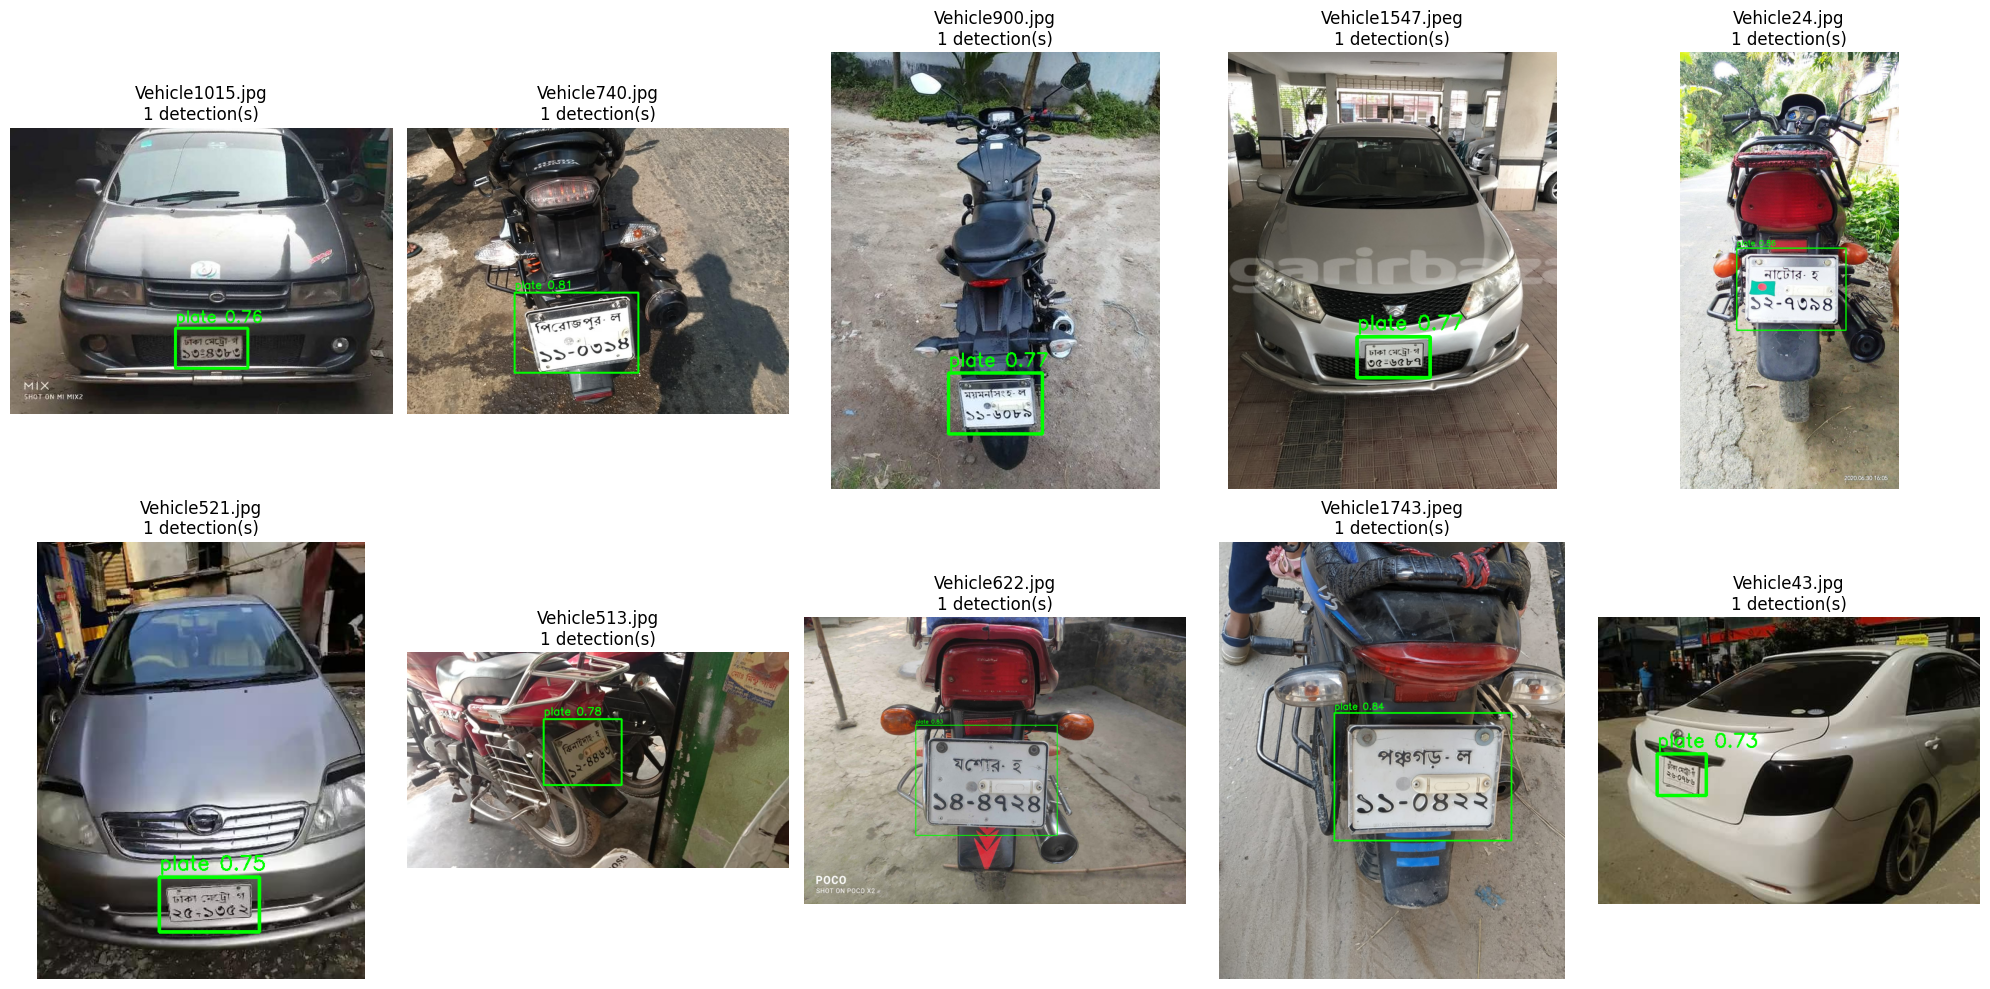

✓ Results visualized successfully!
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results
Results saved to /kaggle/working/annotated_test_results

Annotated images saved to: /kaggle/working/annotated_test_results
You can download them from the 'Output' tab in Kaggle.


In [4]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import random
import glob

# ==============================
# AUTOMATICALLY FIND THE BEST MODEL
# ==============================
# Search for best.pt in the training output directory
possible_paths = glob.glob("/kaggle/working/license_plate_detection/*/weights/best.pt")

if not possible_paths:
    # Fallback: check for last.pt
    possible_paths = glob.glob("/kaggle/working/license_plate_detection/*/weights/last.pt")

if not possible_paths:
    raise FileNotFoundError("No trained model found! Check your training output folder.")

MODEL_PATH = possible_paths[0]  # Take the first (usually only one)
print(f"✓ Found and loaded model: {MODEL_PATH}")

model = YOLO(MODEL_PATH)

# ==============================
# RE-RUN VALIDATION METRICS
# ==============================
print("\nRunning final validation...")
metrics = model.val(data="data.yaml")
print(f"Precision : {metrics.box.mp:.4f}")
print(f"Recall    : {metrics.box.mr:.4f}")
print(f"mAP50     : {metrics.box.map50:.4f}")
print(f"mAP50-95  : {metrics.box.map:.4f}")

# ==============================
# INFERENCE + VISUALIZATION ON TEST IMAGES
# ==============================
test_images_dir = Path("/kaggle/working/dataset/test/images")

image_paths = list(test_images_dir.glob("*.jpg")) + \
              list(test_images_dir.glob("*.jpeg")) + \
              list(test_images_dir.glob("*.png"))

print(f"\nFound {len(image_paths)} test images")

# Sample up to 10 random images
sample_images = random.sample(image_paths, min(10, len(image_paths)))

print(f"\nRunning inference on {len(sample_images)} sample images...\n")

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    results = model(img_path, conf=0.25, iou=0.45, verbose=False)[0]
    
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf.item()
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(img, f"plate {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{img_path.name}\n{len(results.boxes)} detection(s)")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(sample_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

print("✓ Results visualized successfully!")

# ==============================
# OPTIONAL: Save annotated images for download
# ==============================
output_dir = Path("/kaggle/working/annotated_test_results")
output_dir.mkdir(exist_ok=True)

for img_path in sample_images:
    model(img_path, conf=0.25, save=True, project="/kaggle/working", name="annotated_test_results", exist_ok=True)

print(f"\nAnnotated images saved to: {output_dir}")
print("You can download them from the 'Output' tab in Kaggle.")